# Text Alignment: A Method for the Warping of Semantic Space 

by James E. Dobson (James.E.Dobson@Dartmouth.edu)
___

*Note:* This is one in [a series of documents and notebooks](https://jeddobson.github.io/textmining-docsouth/) that will document and evaluate various machine learning and text mining tools for use in literary studies. These notebooks form the practical and critical archive of my new book-in-progress, _Digital Humanities and the Search for a Method_. I have published a critique of some existing methods (Dobson 2015) that takes up some of these concerns and provides some theoretical background for my account of computational methods as used within the humanities.


## Revision Date and Notes:
* 01/18/2018: Initial version (james.e.dobson@dartmouth.edu)
* 01/27/2018: Updated with references


In the past several years the use of word embedding has become (for computational humanists) an increasingly popular activity for mapping possible semantic relations in large datasets and text archives. Trained word vector datasets produced using the word2vec model can map both positive and negative of relations between supplied words. The authors of the word2vec model have provided a set of mappings trained on a Google generated textual archive. This is a contemporary archive and while it has the potential for some use by humanists, the relations extracted from the provided model are not suitable for text mining of historical texts. The semantic space modeled by the word2vec using (what are assumed mostly) contemporary sources has limited use for understanding either a) semantic shift or b) historical relations (Hamilton 2016). 

A method of "aligning" or warping multiple semantic spaces is needed in order to extract potentially more meaningful relations between a text, a set of texts, or the larger historical semantic context in which these texts were constructed and circulated. The term "alignment" is useful in this context because it names the need for producing a deformation of one vector space to another. While individual texts (at the codex or volume level) typically do not provide enough textual data for extracting semantic relations with the word2vec model, collections of texts can be modeled and compared. These collections could be based on author, gender, race, genre, period, etc. These collections of texts can then be modeled via word2vec and aligned to the semantic space generated by iterations of word2vec on other collections.

Aligning the semantic space of one of collection of texts to another enables a greater granulatity of control over the composition of the collective semantic space. Aligning literary to non-literary spaces might present opportunities for examining the degree to which these texts participate in or are outliers of the more general semantic space of their historical moment. Historical relations can be transformed from one moment to another. Alignment might also make it possible to identify creative variations on commonplace relations.

In [1]:
import gensim
import collections
import numpy as np
import scipy.spatial.distance as sd

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [2]:
google_model = gensim.models.Word2Vec.load_word2vec_format('~/Downloads/GoogleNews-vectors-negative300.bin'
                                                           ,binary=True)

In [3]:
# this is a model of the complete DocSouth North American Slave Narrative archive
src_model = gensim.models.Word2Vec.load_word2vec_format('na-slave-narratives.bin',
                                                        binary=True)

In [4]:
# first extract shared vocabulary
common_vocab = [word for word in google_model.vocab if word in src_model.vocab]
common_vectors_google = google_model[common_vocab]
common_vectors_src = src_model[common_vocab]

In [5]:
print("Found",len(common_vocab),"common words")

Found 26304 common words


In [6]:
# now use Sklearn's LinearRegression to combine vector space
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(common_vectors_google, common_vectors_src)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [7]:
shared_vectors = collections.OrderedDict()
for word in google_model.vocab:
    word_vector = lin_model.predict(google_model[word].reshape(1, -1))
    shared_vectors[word] = word_vector.reshape(-1)

In [8]:
# now add words only in src_model
for word in [word for word in src_model.vocab if word not in common_vocab]:
    shared_vectors[word] = src_model[word]

In [9]:
vocab = list(shared_vectors.keys())
shared_embeddings = np.array(list(shared_vectors.values()))

In [10]:
def plot_most_similar_word2vec(word,model,topn=10):
    neighbors = model.most_similar(word,topn=topn)
    
    neighbor_list=list()
    words=list()
    for i in neighbors:
        words.append(i[0])
        neighbor_list.append(model.wv[i[0]])

    pca = PCA(n_components=2)
    plot_data = pca.fit_transform(neighbor_list)

    xs = plot_data[:, 0]
    ys = plot_data[:, 1]
    fig = plt.figure(figsize=(20, 15))

    plt.clf()
    plt.scatter(xs, ys, marker = 'o')
    
    for i, w in enumerate(words):
        plt.annotate(w, xy = (xs[i], ys[i]), xytext = (3, 3),
          textcoords = 'offset points', ha = 'left', va = 'top')
            
    plt.show() 

In [11]:
def combined_most_similar_neighbors(word, topn=20):
    neighbor_list=list()
    ind = vocab.index(word)
    encoding = shared_embeddings[ind]
    scores = sd.cdist([encoding], shared_embeddings, "cosine")[0]
    sorted_ids = np.argsort(scores)
    for i in range(1, topn + 1):
        neighbor_list.append((vocab[sorted_ids[i]], scores[sorted_ids[i]]))
    return(neighbor_list)

In [12]:
def plot_most_similar_neighbors(word,topn=10):
    neighbor_list=list()
    ind = vocab.index(word)
    encoding = shared_embeddings[ind]
    scores = sd.cdist([encoding], shared_embeddings, "cosine")[0]
    sorted_ids = np.argsort(scores)
    words=list()
    for i in range(1, topn + 1):
        words.append(vocab[sorted_ids[i]])
        index = vocab.index(vocab[sorted_ids[i]])
        neighbor_list.append(shared_embeddings[index])
    
    pca = PCA(n_components=2)
    plot_data = pca.fit_transform(neighbor_list)

    xs = plot_data[:, 0]
    ys = plot_data[:, 1]
    fig = plt.figure(figsize=(20, 15))
    plt.clf()
    plt.scatter(xs, ys, marker = 'o')
    
    for i, w in enumerate(words):
        plt.annotate(w, xy = (xs[i], ys[i]), xytext = (3, 3),
          textcoords = 'offset points', ha = 'left', va = 'top')
            
    plt.show() 

In [13]:
src_model.most_similar(positive=['nat_turner', 'woman_suffrage'], negative=['insurrection'])

[('lucretia_mott', 0.6808589696884155),
 ('gage', 0.604787290096283),
 ('miss_susan_b', 0.6004625558853149),
 ('john_g_whittier', 0.5983288884162903),
 ('broadway_tabernacle', 0.5822384357452393),
 ('folsom', 0.5798661708831787),
 ('boston_post', 0.5795968770980835),
 ('garrison_phillips', 0.5787340402603149),
 ('h_garnet', 0.5783672332763672),
 ('alcott', 0.572452187538147)]

In [14]:
src_model.most_similar("frederick_douglass",topn=20)

[('mr_douglass', 0.6789201498031616),
 ('wendell_phillips', 0.6422789692878723),
 ('william_lloyd_garrison', 0.6040972471237183),
 ('autobiographies', 0.5962321162223816),
 ('douglass', 0.589881420135498),
 ('decoration_day', 0.5729281306266785),
 ('mr_garrison', 0.5727505683898926),
 ("douglass's", 0.5660401582717896),
 ('anti_slavery_convention', 0.563313364982605),
 ("mr_douglass's", 0.5495040416717529),
 ('anti_slavery_movement', 0.5458614826202393),
 ('agitator', 0.5411466360092163),
 ('various_phases', 0.5406709909439087),
 ('patrick_henry', 0.5403376817703247),
 ('harriet_beecher_stowe', 0.5360968708992004),
 ('gerritt_smith', 0.5353233814239502),
 ('henry_wilson', 0.534428596496582),
 ('charles_l_remond', 0.5323055386543274),
 ('journalistic', 0.5313712954521179),
 ('autographs', 0.5309398174285889)]

In [15]:
google_model.most_similar("Frederick_Douglass",topn=20)

[('Fredrick_Douglass', 0.6643674969673157),
 ('Harriet_Tubman', 0.6538548469543457),
 ('Langston_Hughes', 0.6378294825553894),
 ('WEB_Dubois', 0.6361298561096191),
 ('abolitionist_Frederick_Douglass', 0.6212432384490967),
 ('WEB_DuBois', 0.6167810559272766),
 ('Sojourner_Truth', 0.6166481971740723),
 ('Booker_T._Washington', 0.5926769971847534),
 ('Phillis_Wheatley', 0.5811346769332886),
 ('Thurgood_Marshall', 0.5717906355857849),
 ('G._Woodson', 0.568604588508606),
 ('WEB_Du_Bois', 0.5670568943023682),
 ('Ralph_Bunche', 0.5626702904701233),
 ('Phyllis_Wheatley', 0.5608549118041992),
 ('Mary_McLeod_Bethune', 0.5546070337295532),
 ('Fannie_Lou_Hamer', 0.5512949228286743),
 ('Tubman', 0.5479763746261597),
 ('Benjamin_Banneker', 0.5479563474655151),
 ('Eleanor_Roosevelt', 0.5426533222198486),
 ('Malcolm_X', 0.5422308444976807)]

In [16]:
combined_most_similar_neighbors("frederick_douglass",topn=20)

[('mr_douglass', 0.32107986263292665),
 ('wendell_phillips', 0.35772104992424181),
 ('william_lloyd_garrison', 0.39590273197090209),
 ('BookExpo', 0.39807692986095866),
 ('Andrei_Sakharov', 0.40841162322395386),
 ('douglass', 0.41011861214084999),
 ('feminist_icon', 0.41086614525319021),
 ('Julian_Bond', 0.42012511674663988),
 ('Paul_Robeson', 0.42399577753377249),
 ('Steinem', 0.42421127121989977),
 ('decoration_day', 0.42707189705680892),
 ('mr_garrison', 0.42724955171080203),
 ('Louise_Mirrer', 0.42754550148413384),
 ('historian_Doris_Kearns', 0.42768691113746837),
 ('Wally_Serote', 0.43090307555114549),
 ('Mahashweta_Devi', 0.43156523792348467),
 ('Tony_Judt', 0.43233772692871941),
 ("douglass's", 0.43395979808404406),
 ('Harriet_Tubman', 0.43432488585549678),
 ('Eugene_V._Debs', 0.43469860966633733)]

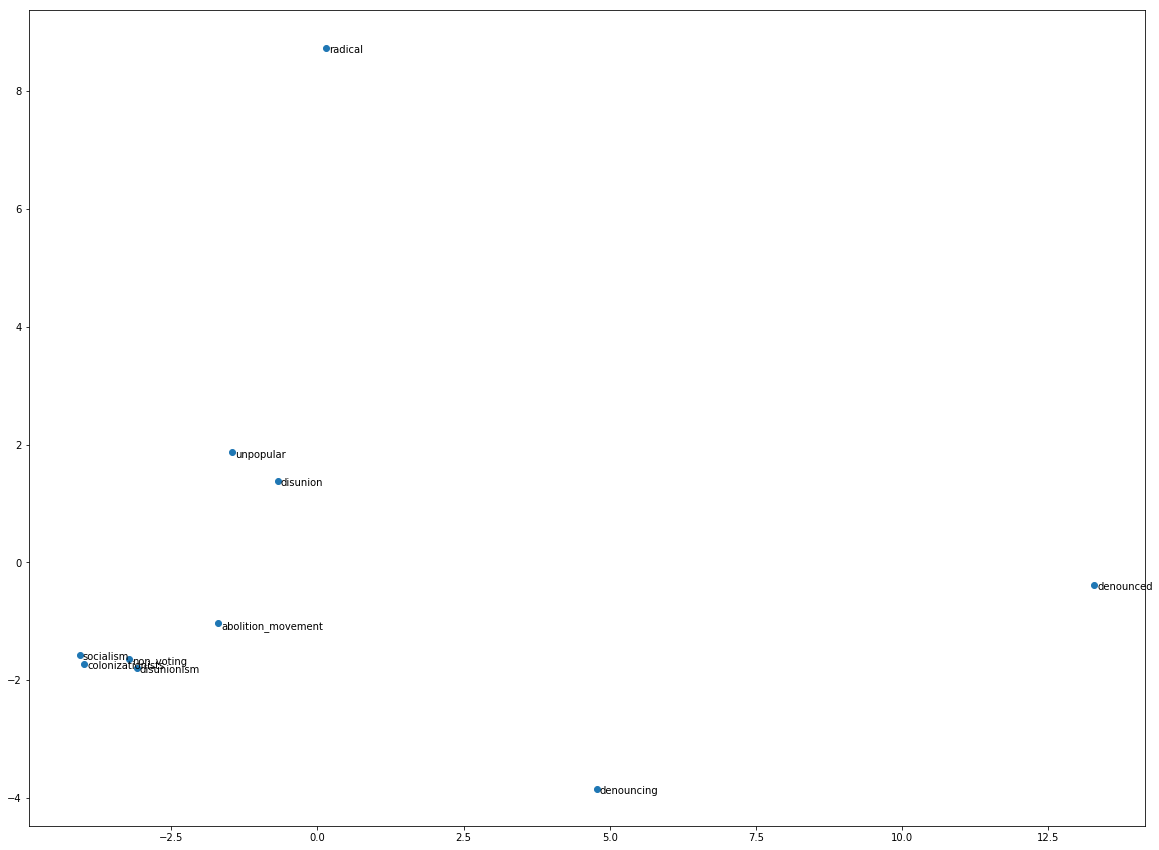

In [17]:
plot_most_similar_word2vec("abolitionism",src_model)

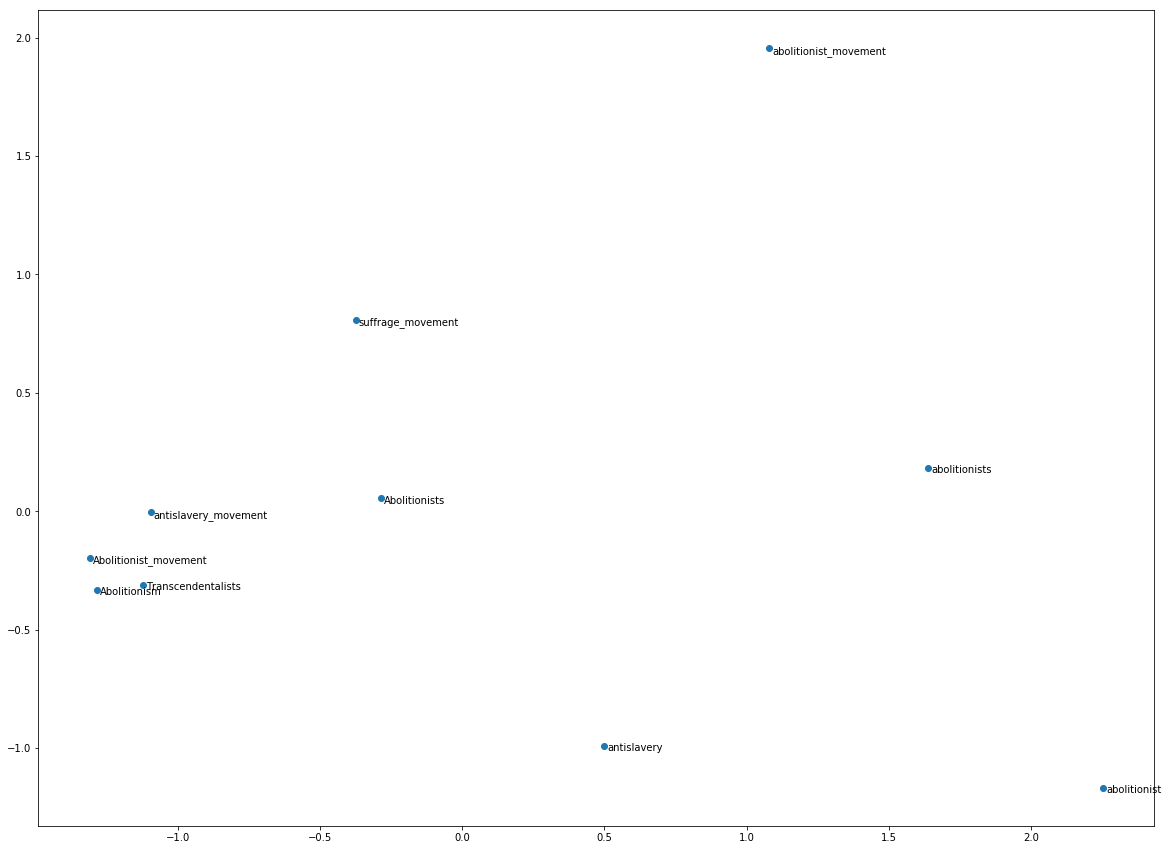

In [18]:
plot_most_similar_word2vec("abolitionism",google_model)

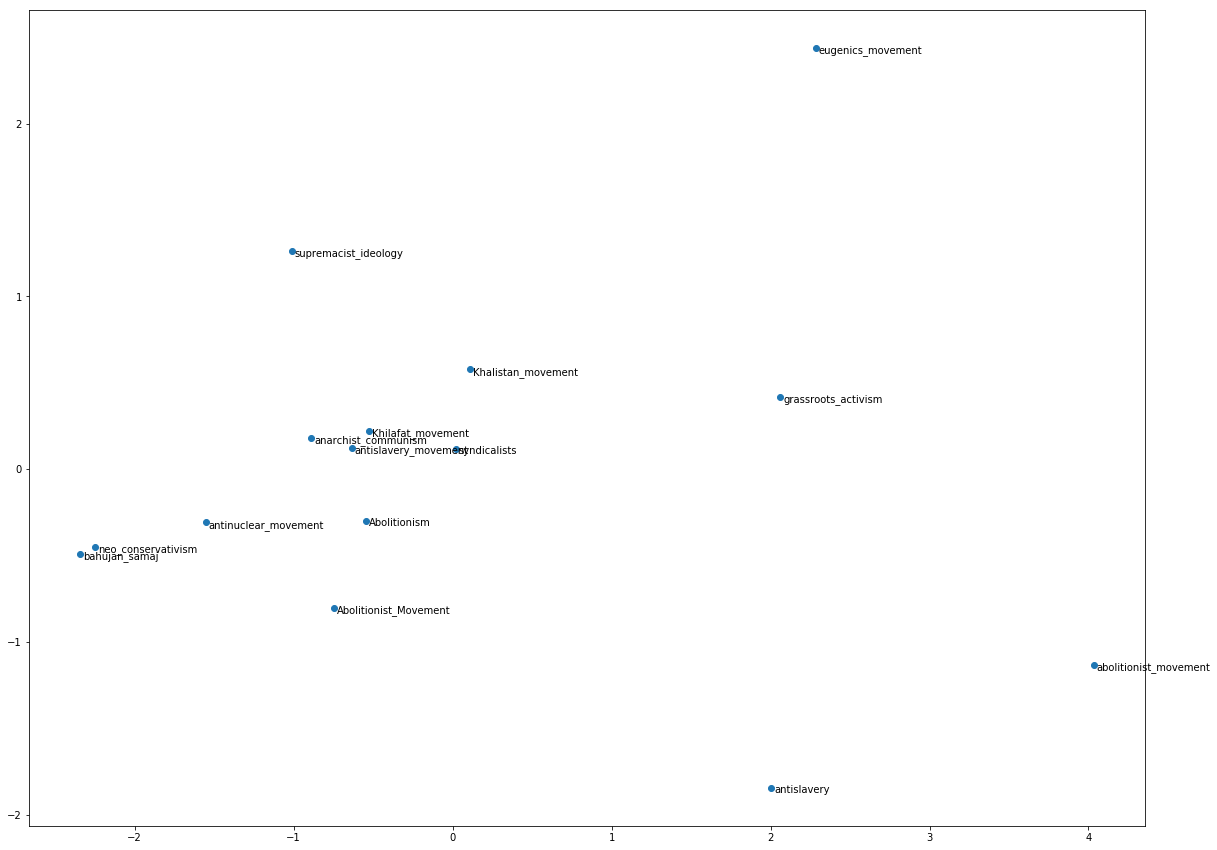

In [19]:
plot_most_similar_neighbors("abolitionism",topn=15)

# References

Hamilton, William L., Jure Leskovec, and Dan Jurafsky. (2016) “Diachronic Word Embeddings Reveal Statistical Laws of Semantic Change,” ArXiv Preprint ArXiv:1605.09096, https://arxiv.org/abs/1605.09096.